In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils import shuffle

plt.rcParams.update({
    "figure.figsize": (7, 4),
    "font.size": 12
})


In [2]:
def load_monk(path):
    data = pd.read_csv(path, sep=" ", header=None)
    data = data.dropna(axis=1)  # remove empty columns
    
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:7].values  # 6 symbolic features
    
    return X, y


In [4]:
encoder = OneHotEncoder(sparse_output=False)


In [5]:
def evaluate_knn(
    X_train, y_train,
    X_test, y_test,
    k=3,
    n_trials=10
):
    acc_tr, acc_ts = [], []
    mse_tr, mse_ts = [], []
    
    for _ in range(n_trials):
        Xtr, ytr = shuffle(X_train, y_train, random_state=None)
        
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(Xtr, ytr)
        
        ytr_pred = model.predict(Xtr)
        yts_pred = model.predict(X_test)
        
        acc_tr.append(accuracy_score(ytr, ytr_pred))
        acc_ts.append(accuracy_score(y_test, yts_pred))
        
        mse_tr.append(mean_squared_error(ytr, ytr_pred))
        mse_ts.append(mean_squared_error(y_test, yts_pred))
    
    return {
        "acc_tr": np.mean(acc_tr),
        "acc_ts": np.mean(acc_ts),
        "mse_tr": np.mean(mse_tr),
        "mse_ts": np.mean(mse_ts)
    }


In [6]:
def learning_curve_knn(
    X_train, y_train,
    X_test, y_test,
    k=3
):
    sizes = np.linspace(0.2, 1.0, 8)
    
    acc_tr, acc_ts = [], []
    mse_tr, mse_ts = [], []
    
    for s in sizes:
        n = int(len(X_train) * s)
        X_sub = X_train[:n]
        y_sub = y_train[:n]
        
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_sub, y_sub)
        
        ytr_pred = model.predict(X_sub)
        yts_pred = model.predict(X_test)
        
        acc_tr.append(accuracy_score(y_sub, ytr_pred))
        acc_ts.append(accuracy_score(y_test, yts_pred))
        
        mse_tr.append(mean_squared_error(y_sub, ytr_pred))
        mse_ts.append(mean_squared_error(y_test, yts_pred))
    
    return sizes, acc_tr, acc_ts, mse_tr, mse_ts


In [7]:
monk_paths = {
    "MONK1": (
        "../data/monk/monks-1.train",
        "../data/monk/monks-1.test"
    ),
    "MONK2": (
        "../data/monk/monks-2.train",
        "../data/monk/monks-2.test"
    ),
    "MONK3": (
        "../data/monk/monks-3.train",
        "../data/monk/monks-3.test"
    )
}

results = {}
curves = {}

for name, (tr_path, ts_path) in monk_paths.items():
    Xtr_raw, ytr = load_monk(tr_path)
    Xts_raw, yts = load_monk(ts_path)
    
    Xtr = encoder.fit_transform(Xtr_raw)
    Xts = encoder.transform(Xts_raw)
    
    k = 3  # small model as requested
    
    results[name] = evaluate_knn(Xtr, ytr, Xts, yts, k=k)
    curves[name] = learning_curve_knn(Xtr, ytr, Xts, yts, k=k)


In [8]:
table = []

for monk, r in results.items():
    table.append([
        monk,
        "k=3",
        f"{r['mse_tr']:.4f} / {r['mse_ts']:.4f}",
        f"{r['acc_tr']*100:.1f} / {r['acc_ts']*100:.1f}"
    ])

df_results = pd.DataFrame(
    table,
    columns=[
        "Task",
        "#Units / Hyperparams",
        "MSE (TR / TS)",
        "Accuracy (TR / TS) %"
    ]
)

df_results


,Task,#Units / Hyperparams,MSE (TR / TS),Accuracy (TR / TS) %
0,MONK1,k=3,0.0919 / 0.1933,90.8 / 80.7
1,MONK2,k=3,0.2249 / 0.3745,77.5 / 62.5
2,MONK3,k=3,0.0770 / 0.1454,92.3 / 85.5


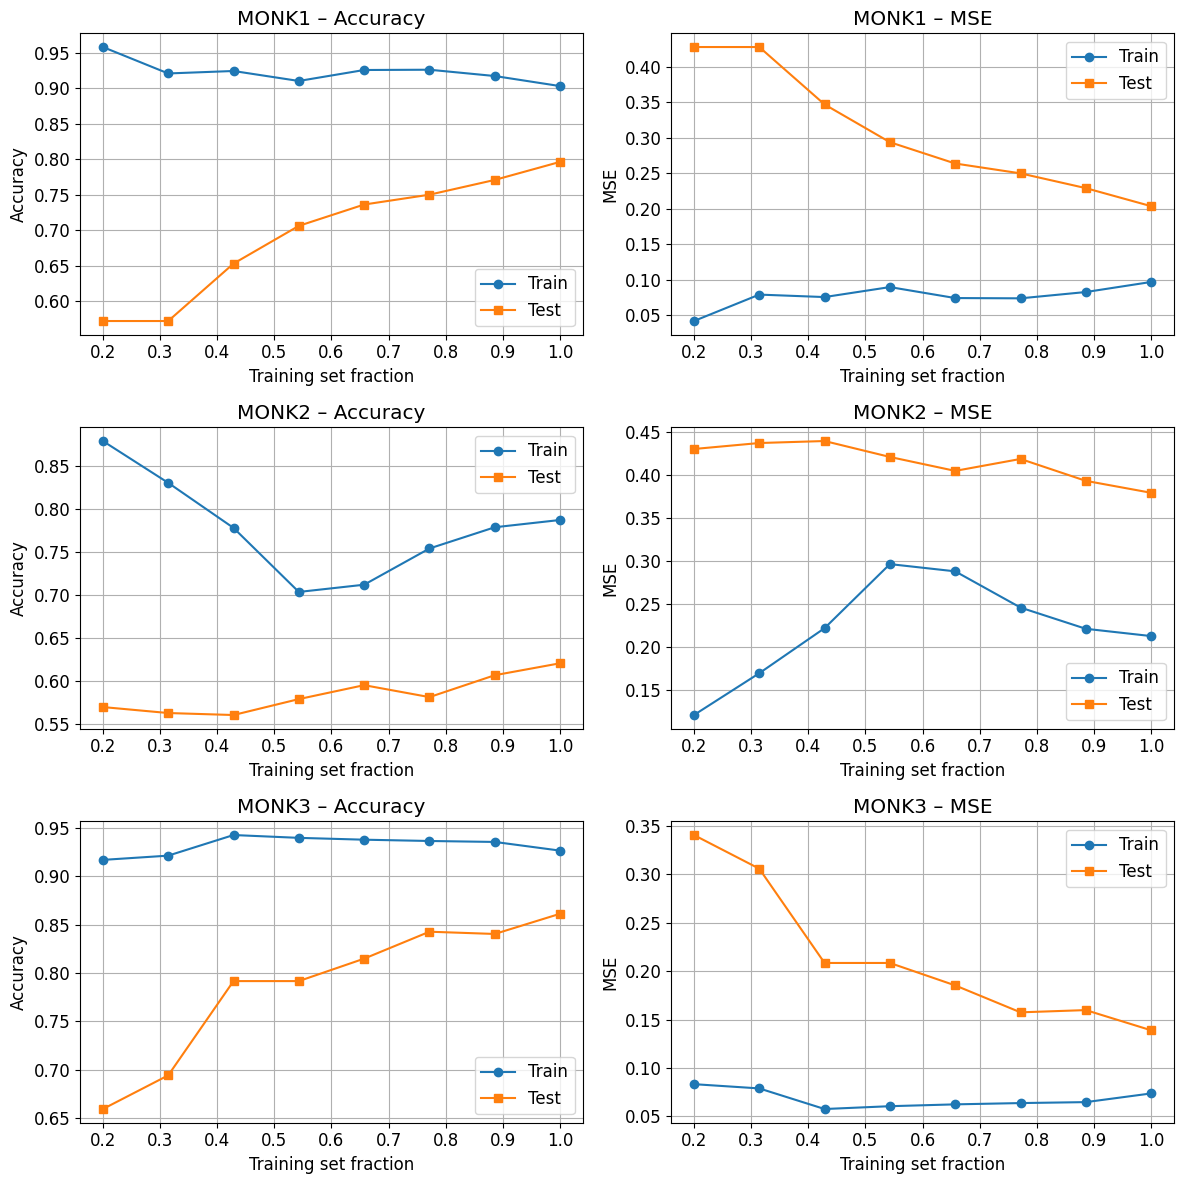

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, monk in enumerate(curves):
    sizes, acc_tr, acc_ts, mse_tr, mse_ts = curves[monk]
    
    # Accuracy
    axes[i, 0].plot(sizes, acc_tr, marker="o", label="Train")
    axes[i, 0].plot(sizes, acc_ts, marker="s", label="Test")
    axes[i, 0].set_title(f"{monk} – Accuracy")
    axes[i, 0].set_xlabel("Training set fraction")
    axes[i, 0].set_ylabel("Accuracy")
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    
    # MSE
    axes[i, 1].plot(sizes, mse_tr, marker="o", label="Train")
    axes[i, 1].plot(sizes, mse_ts, marker="s", label="Test")
    axes[i, 1].set_title(f"{monk} – MSE")
    axes[i, 1].set_xlabel("Training set fraction")
    axes[i, 1].set_ylabel("MSE")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()
